**Project 3 Submission**

* Student name: Jenny Kreiger
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Victor Geislinger
* Blog post URL: 

# Introduction

## Business case

Oregon offers many exciting opportunities for investment in real estate, with [a market that has recovered strongly since the lows of the Great Recession](https://listwithclever.com/real-estate-blog/top-5-best-real-estate-investment-markets-in-oregon/). Just like anywhere else, there are risks to investing in real estate, and in Oregon there is a risk that housing market growth is slowing or plateauing, and that property values cannot increase much more without outstripping wage growth. In [an article for Forbes in April 2019](https://www.forbes.com/sites/ingowinzer/2019/04/25/how-best-to-invest-in-real-estate-in-the-northwest/#47f25e466150), Ingo Winzer recommended that investors focus on apartments, since the rental market will continue to grow as Oregon's cities expand. 

This project uses data from Zillow to determine the top 5 zipcodes for real estate investment in Oregon and forecasts their growth over the next five years. The dataset contains the median home prices per zipcode recorded monthly over the period from April 1996 to April 2018. 

To select the top 5 zipcodes, I looked at return on investment over 5-, 10-, and 22-year periods (as far back as the data goes) and selected zipcodes that were in the top 10 for growth in one or more of these periods. I calculated how much median price dropped during the recession and ranked the zipcodes according to which suffered the least loss. I also collected data on how many properties are currently listed for sale in each zipcode.

After selecting the top 5 zipcodes, I used time series modeling to predict how the median home price will grow in each over the next 5 years. Skip to **Interpretations and recommendations** below to read my summary recommendations for investors.

## Import packages and load data

First I will import packages and the dataset. Note that I will be using Facebook Prophet for modeling; I will explain this choice in more detail in the **Modeling** section below.

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('colorblind')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet as proph

In [2]:
# Read in the data
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Note that each row in this DataFrame represents a zipcode. The first seven columns contain identifying information for the zipcode, and the subsequent columns contain the median home price in that zipcode at monthly intervals from April 1996 to April 2018.

My analysis is limited to zipcodes in Oregon, so I will subset the data to just that state. A couple of these columns are not useful for my analysis, so I'm going to drop them right away to avoid confusion.

In [3]:
# Select Oregon data and drop columns that definitely aren't needed
oregon = df[df.State == 'OR']
oregon.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [4]:
# Check number of OR zipcodes
oregon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 135 to 14716
Columns: 270 entries, RegionName to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 474.2+ KB


This leaves me with 224 zipcodes to analyze. Are there any missing values?

In [5]:
# Allow display of a greater number of rows
pd.set_option('display.max_rows', 500)

# Check for missing values
oregon.isna().sum()

RegionName     0
City           0
State          0
Metro          8
CountyName     0
1996-04       14
1996-05       14
1996-06       14
1996-07       14
1996-08       14
1996-09       14
1996-10       14
1996-11       14
1996-12       14
1997-01       14
1997-02       14
1997-03       14
1997-04       14
1997-05       14
1997-06       14
1997-07       14
1997-08       14
1997-09       14
1997-10       14
1997-11       14
1997-12       14
1998-01       14
1998-02       14
1998-03       14
1998-04       14
1998-05       14
1998-06       14
1998-07       14
1998-08       14
1998-09       14
1998-10       14
1998-11       14
1998-12       14
1999-01       14
1999-02       14
1999-03       14
1999-04       14
1999-05       14
1999-06       14
1999-07       14
1999-08       14
1999-09       14
1999-10       14
1999-11       14
1999-12       14
2000-01       14
2000-02       14
2000-03       14
2000-04       14
2000-05       14
2000-06       14
2000-07       14
2000-08       14
2000-09       

Yes, there appear to be some missing values in the dataset, mostly for the earlier dates. I will backfill missing values row-wise at this point and check that they have been resolved. Note that backfilling is not actually a good strategy in the `Metro` column, but I will be dropping this column anyway.

In [6]:
# Back-fill any missing values
oregon = oregon.fillna(method='bfill', axis=0)

# Check that NaNs are all resolved (should print nothing)
for col in oregon.columns:
    if oregon.isna().sum()[col] > 0:
        print(col)

I now have a clean dataset for the state of Oregon.

## Create custom functions

I need a few custom functions to avoid repeating code, so I will define those here.

In [7]:
def melt_it(df):
    '''Melts data from wide to long format. Returns time series in a 
       format suited for use with Facebook Prophet.
       
       Dependencies: pandas.'''
    
    melted = pd.melt(df, var_name='ds')
    melted['ds'] = pd.to_datetime(melted['ds'], infer_datetime_format=True)
    melted.columns = ['ds', 'y']
    
    return melted

In [8]:
def melt_plot(df, title):
    '''Melts time series data from wide to long format and produces a quick 
       line plot.'''
    
    melted = melt_it(df)
    
    plt.figure(figsize=(16,4))
    fig = plt.plot(melted['ds'], melted['y']);
    plt.title('Median home price in {}'.format(title))
    plt.ylabel('Median home price ($)')
    
    return melted, fig

In [9]:
def prep_and_plot(data, title):
    '''Performs 90:10 train-test split on time series data of n=264. Plots
       the train and test series.
       
       Dependencies: matplotlib.'''
    
    # Split the data
    train = data[:236]
    test = data[236:]
    
    # Reset index of test set
    test.reset_index(inplace=True)
    test.drop('index', axis=1, inplace=True)
    
    # Plot the data
    plt.plot(train['ds'], train['y'], label='train');
    plt.plot(test['ds'], test['y'], label='test')
    plt.legend()
    plt.title('Training and validation data for {}'.format(title))
    plt.show();
    
    return train, test

In [10]:
def proph_it(train, test, whole, interval=0.95, forecast_periods1=28, 
             forecast_periods2=60):
    '''Uses Facebook Prophet to fit model to train set, evaluate performance
       with test set, and forecast with whole dataset. The model has a 95%
       confidence interval by default.
       
       Remember: datasets need to have two columns, `ds` and `y`.
       Dependencies: fbprophet
       Parameters:
          train: training data
          test: testing/validation data
          whole: all available data for forecasting
          interval: confidence interval (percent)
          forecast_periods1: number of months for forecast on training data
          forecast_periods2: number of months for forecast on whole dataset'''
    
    # Fit model to training data and forecast
    model = proph(interval_width=interval)
    model.fit(train)
    future = model.make_future_dataframe(periods=forecast_periods1, freq='MS')
    forecast = model.predict(future)
    
    # Plot the model and forecast
    model.plot(forecast, uncertainty=True)
    plt.title('Training data with forecast')
    plt.legend();
    
    # Make predictions and compare to test data
    y_pred = model.predict(test)
    
    # Plot the model, forecast, and actual (test) data
    model.plot(y_pred, uncertainty=True)
    plt.plot(test['ds'], test['y'], color='r', label='actual')
    plt.title('Validation data v. forecast')
    plt.legend();
    
    # Fit a new model to the whole dataset and forecast
    model2 = proph(interval_width=0.95)
    model2.fit(whole)
    future2 = model2.make_future_dataframe(periods=forecast_periods2, 
                                          freq='MS')
    forecast2 = model2.predict(future2)
    
    # Plot the model and forecast
    model2.plot(forecast2, uncertainty=True)
    plt.title('{}-month forecast'.format(forecast_periods2))
    plt.legend();
    
    # Plot the model components
    model2.plot_components(forecast);
    
    return y_pred, forecast2

In [11]:
def last_forecast(df):
    '''Returns last predicted value, upper and lower bounds from a DataFrame 
       of predicted values returned by Facebook Prophet. 
       
       In other words, returns the latest prediction.'''
    
    date = str(df[-1:]['ds'])
    value = round(float(df[-1:]['yhat']),2)
    upper = round(float(df[-1:]['yhat_upper']),2)
    lower = round(float(df[-1:]['yhat_lower']),2)
    ci = (upper, lower)
    
    print('Prediction for last date of period:')
    print('Median home price: ${}'.format(value))
    print('95% CI: {}'.format(ci))

    return value, ci

# Identify top 5 zipcodes for investment in Oregon

Because the dataset contains only median home prices for each zipcode, I will need to use those to determine which are the best 5 zipcodes for investment. (Typically, an analysis like this would make use of other data as well, like features of particular houses, vacancy rates, etc.)

The dataset covers a 22-year period, so I will look for zipcodes that have shown the return on investment over various time intervals. I calculate this by finding the difference between median home price at two dates and dividing that by the price at the earlier date to get a percent change in price over that time interval.

Note that since I backfilled missing values above, zipcodes that had missing values for the earlier dates will probably show less growth than they might have if the data had not been missing. I don't expect this to have a huge impact on the analysis, and there's not much I could do about it anyway.

## Greatest ROI 1996-2018

Which zipcodes saw the greatest ROI over the period from 1996 to 2018?

In [12]:
# Calculate growth over 22-year period and select top 10 by growth
oregon_copy = oregon.copy()
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['1996-04']
oregon_copy['roi'] = oregon_copy['growth']/oregon_copy['1996-04']*100
top_10_growth_all = oregon_copy.sort_values('roi', ascending=False)[:10]
top_10_growth_all

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth,roi
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,527300,531100,534600,537100,540300,543600,543300,540300,455800.0,539.408284
2520,97211,Portland,OR,Portland,Multnomah,88000.0,88700.0,89400.0,90200.0,91000.0,...,457500,456400,456100,458800,463200,468000,472300,474300,386300.0,438.977273
949,97330,Corvallis,OR,Corvallis,Benton,72000.0,71900.0,71800.0,71500.0,71200.0,...,357600,361000,363700,367100,370400,369500,365300,362500,290500.0,403.472222
1769,97217,Portland,OR,Portland,Multnomah,90600.0,91500.0,92300.0,93200.0,94000.0,...,434000,433100,433600,436100,439100,442400,445100,445000,354400.0,391.169978
4423,97333,Corvallis,OR,Corvallis,Benton,67300.0,67500.0,67600.0,67600.0,67600.0,...,323500,326400,329400,332300,334400,333200,329600,326700,259400.0,385.438336
2557,97214,Portland,OR,Portland,Multnomah,136700.0,137700.0,138800.0,139900.0,141000.0,...,590000,587100,586200,589400,593800,597200,598000,596300,459600.0,336.210680
3130,97203,Portland,OR,Portland,Multnomah,88000.0,88700.0,89500.0,90300.0,91200.0,...,373600,373400,373500,375000,377200,379300,379800,378600,290600.0,330.227273
8743,97370,Philomath,OR,Corvallis,Benton,69300.0,69700.0,70000.0,70300.0,70600.0,...,281300,284400,287100,290100,292900,293000,291800,291500,222200.0,320.634921
3153,97321,Albany,OR,Albany,Linn,71600.0,71900.0,72200.0,72400.0,72500.0,...,288600,289500,289700,290700,292100,293200,295200,297700,226100.0,315.782123
999,97202,Portland,OR,Portland,Multnomah,132600.0,133400.0,134200.0,135000.0,135800.0,...,522700,521700,522200,525700,530100,534100,535900,535000,402400.0,303.469080


The zipcodes in the table above are the top 10 by ROI over the period from 1996-2018. Note that they are all mostly in the areas of Portland and Corvallis, with one in Albany. The huge increases&mdash;up to 539\% ROI&mdash;reflect rapid growth in these areas over this period. 

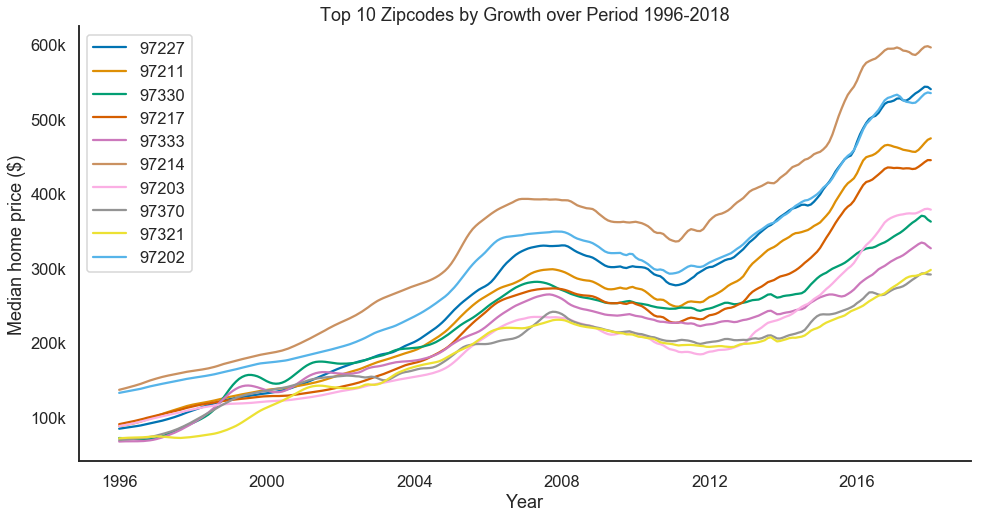

In [13]:
# Plot the top 10 zipcodes by growth, 1996-2018
xticks = ['1996-04', '2000-04', '2004-04', '2008-04', '2012-04', '2016-04']
xlabels = ['1996', '2000', '2004', '2008', '2012', '2016']
yticks = [100000, 200000, 300000, 400000, 500000, 600000]
ylabels = ['100k', '200k', '300k', '400k', '500k', '600k']
plt.figure(figsize=(16,8))
for n, index in enumerate(top_10_growth_all.index):
    sample = top_10_growth_all.loc[index,'1996-04':'2018-04']
    zipcode = top_10_growth_all.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_all.loc[index]['RegionName'])
plt.xticks(xticks, labels=xlabels)
plt.yticks(yticks, labels=ylabels)
plt.legend()
plt.title('Top 10 Zipcodes by Growth over Period 1996-2018')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
sns.despine()
plt.show();

## Greatest ROI 2008-2018

Next I will identify the top 10 zipcodes by ROI over the last decade. In 2008, most zipcodes were hitting their pre-crash peak for house prices, so this ten-year interval encompasses both the crash and subsequent recovery.

In [14]:
# Calculate growth over 10 year period and identify top 10 zipcodes by growth
oregon_copy = oregon.copy()
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['2008-04']
oregon_copy['roi'] = oregon_copy['growth']/oregon_copy['2008-04']*100
top_10_growth_10 = oregon_copy.sort_values('roi', ascending=False)[:10]
top_10_growth_10

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth,roi
1769,97217,Portland,OR,Portland,Multnomah,90600.0,91500.0,92300.0,93200.0,94000.0,...,434000,433100,433600,436100,439100,442400,445100,445000,173200.0,63.723326
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,527300,531100,534600,537100,540300,543600,543300,540300,209700.0,63.430127
644,97206,Portland,OR,Portland,Multnomah,96600.0,97600.0,98600.0,99600.0,100700.0,...,371900,372000,373000,374900,377100,379600,381800,382200,147000.0,62.500000
3130,97203,Portland,OR,Portland,Multnomah,88000.0,88700.0,89500.0,90300.0,91200.0,...,373600,373400,373500,375000,377200,379300,379800,378600,145500.0,62.419562
7028,97218,Portland,OR,Portland,Multnomah,100800.0,101800.0,102900.0,103900.0,104800.0,...,381400,381300,381700,382500,383400,384900,387200,388400,146500.0,60.562216
2520,97211,Portland,OR,Portland,Multnomah,88000.0,88700.0,89400.0,90200.0,91000.0,...,457500,456400,456100,458800,463200,468000,472300,474300,178400.0,60.290639
5968,97215,Portland,OR,Portland,Multnomah,134400.0,135400.0,136400.0,137400.0,138400.0,...,528800,529600,531000,533800,536900,540400,542300,541400,192400.0,55.128940
6568,97216,Portland,OR,Portland,Multnomah,103700.0,104500.0,105300.0,106100.0,107000.0,...,319500,319900,320900,323200,325900,328900,331900,333600,117700.0,54.515980
999,97202,Portland,OR,Portland,Multnomah,132600.0,133400.0,134200.0,135000.0,135800.0,...,522700,521700,522200,525700,530100,534100,535900,535000,186000.0,53.295129
5713,97232,Portland,OR,Portland,Multnomah,174100.0,175300.0,176500.0,177700.0,178900.0,...,678600,680300,682300,686600,692200,696500,695500,690600,238200.0,52.652520


As we might have expected, Portland's rapid expansion in the last decade is reflected here. Zipcodes 97217 and 97227 are the top performers, with 63.4\% and 63.7\% ROI, respectively.

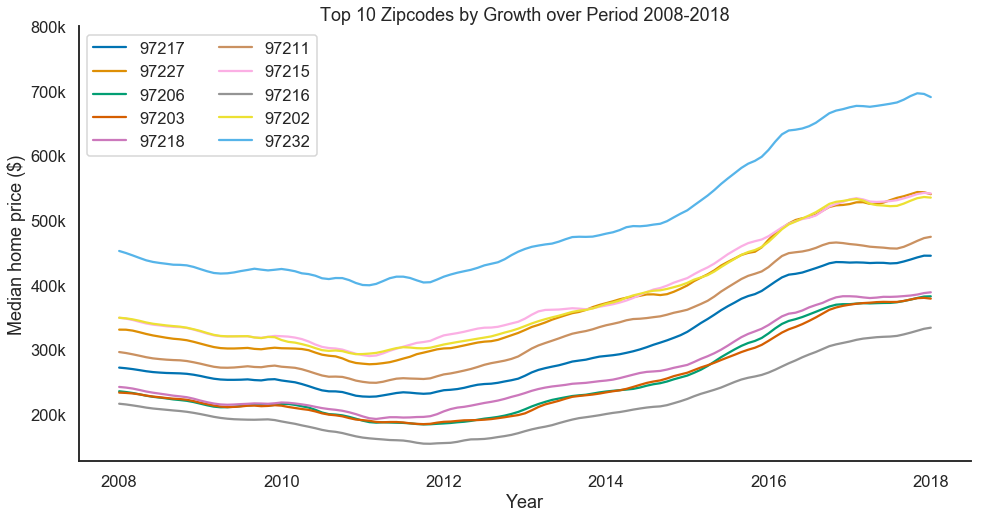

In [15]:
# Plot the top 10 zipcodes by growth in the period 2008-2018
xticks = ['2008-04', '2010-04', '2012-04', '2014-04', '2016-04', '2018-04']
xlabels = ['2008', '2010', '2012', '2014', '2016', '2018']
yticks = [200000, 300000, 400000, 500000, 600000, 700000, 800000]
ylabels = ['200k', '300k', '400k', '500k', '600k', '700k', '800k']

plt.figure(figsize=(16,8))
for index in top_10_growth_10.index:
    sample = top_10_growth_10.loc[index,'2008-04':'2018-04']
    zipcode = top_10_growth_10.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_10.loc[index]['RegionName'])
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.legend(loc='upper left', ncol=2)
plt.title('Top 10 Zipcodes by Growth over Period 2008-2018')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
sns.despine()
plt.show();

## Greatest ROI 2013-2018

Finally, I will identify the top performers over the last five years. Any zipcode that has been a top performer at this time interval seems likely to continue performing well in the next five years.

In [16]:
# Calculate growth over the past 5 years and find the top 10 performers
oregon_copy = oregon.copy()
oregon_copy['growth'] = oregon_copy['2018-04'] - oregon_copy['2013-04']
oregon_copy['roi'] = oregon_copy['growth']/oregon_copy['2013-04']*100
top_10_growth_5 = oregon_copy.sort_values('roi', ascending=False)[:10]
top_10_growth_5

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,growth,roi
3081,97266,Portland,OR,Portland,Multnomah,98900.0,99700.0,100400.0,101000.0,101700.0,...,286800,288000,290100,293400,297200,300300,302900,303900,152300.0,100.461741
6854,97739,La Pine,OR,Bend,Deschutes,71500.0,72300.0,73200.0,74100.0,74900.0,...,217100,217400,218200,220700,221900,224300,230300,235800,117700.0,99.661304
12763,97026,Gervais,OR,Salem,Marion,85100.0,85300.0,85600.0,85800.0,86200.0,...,214500,217800,219800,221500,225300,228900,233000,236500,114800.0,94.330320
6568,97216,Portland,OR,Portland,Multnomah,103700.0,104500.0,105300.0,106100.0,107000.0,...,319500,319900,320900,323200,325900,328900,331900,333600,160200.0,92.387543
4401,97071,Woodburn,OR,Salem,Marion,97700.0,97600.0,97600.0,97700.0,98000.0,...,241100,244900,248700,251100,252600,253900,256000,257600,123500.0,92.095451
8953,97760,Terrebonne,OR,Roseburg,Jefferson,93400.0,93400.0,93400.0,93400.0,93300.0,...,337200,341000,343300,344800,346100,346700,348700,351900,166700.0,90.010799
2419,97233,Portland,OR,Portland,Multnomah,110800.0,111500.0,112300.0,113000.0,113700.0,...,276000,277100,278600,280900,283600,286300,288400,288800,136100.0,89.129011
3471,97220,Portland,OR,Portland,Multnomah,103000.0,104000.0,105000.0,105900.0,106800.0,...,324900,325300,325800,328000,331100,333600,335100,335300,157400.0,88.476672
3130,97203,Portland,OR,Portland,Multnomah,88000.0,88700.0,89500.0,90300.0,91200.0,...,373600,373400,373500,375000,377200,379300,379800,378600,177600.0,88.358209
644,97206,Portland,OR,Portland,Multnomah,96600.0,97600.0,98600.0,99600.0,100700.0,...,371900,372000,373000,374900,377100,379600,381800,382200,174900.0,84.370478


In the last five years, 97266 in Portland has seen a 100\% ROI, with 97739 in Bend coming in a close second with 99\% ROI. Portland's growth over this period may be expected, and Bend has become a hotspot for tourism and craft brewing in recent years.

Let's take a look at their performance over the five-year period.

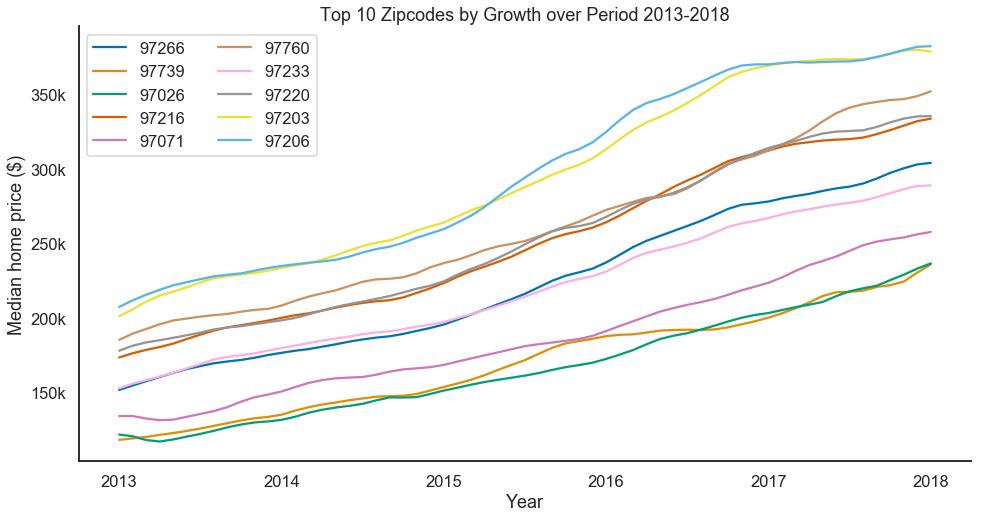

In [17]:
# Plot the top 10 zipcodes for growth over the last 5 years
xticks = ['2013-04', '2014-04', '2015-04', '2016-04', '2017-04', '2018-04']
xlabels = ['2013', '2014', '2015', '2016', '2017', '2018']
yticks = [150000, 200000, 250000, 300000, 350000] 
ylabels = ['150k', '200k', '250k', '300k', '350k']

plt.figure(figsize=(16,8))
for index in top_10_growth_5.index:
    sample = top_10_growth_5.loc[index,'2013-04':'2018-04']
    zipcode = top_10_growth_5.loc[index]['RegionName']
    plt.plot(sample, label=top_10_growth_5.loc[index]['RegionName'])
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.legend(loc='upper left', ncol=2)
plt.title('Top 10 Zipcodes by Growth over Period 2013-2018')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
sns.despine()
plt.show();

## The top 5 zips

Based on the analyses above, I select the following zipcodes as the top 5 for investment in Oregon (in no particular order):
- 97266 (Portland): ranked 1st for ROI over the last 5 years
- 97739 (La Pine/Bend): ranked 2nd for ROI over the last 5 years
- 97217 (Portland): ranked 1st for ROI over the last 10 years
- 97227 (Portland): ranked 2nd for ROI over the last 10 years
- 97203 (Portland): in the top 10 for ROI at 5-, 10-, and 22-year intervals

To strike a balance between strong performers in the short and long terms, I selected the top two zipcodes for ROI at the 5- and 10-year intervals. I also included 97203, the only zipcode to make the top 10 for ROI at all three time intervals. 

Let's examine the time series for the top 5 zipcodes:

In [18]:
top5_zips = ['97266', '97739', '97217', '97227', '97203']

top_data = oregon[oregon.RegionName.isin(top5_zips)]
top_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1769,97217,Portland,OR,Portland,Multnomah,90600.0,91500.0,92300.0,93200.0,94000.0,...,433700,434100,434000,433100,433600,436100,439100,442400,445100,445000
3081,97266,Portland,OR,Portland,Multnomah,98900.0,99700.0,100400.0,101000.0,101700.0,...,283100,285100,286800,288000,290100,293400,297200,300300,302900,303900
3130,97203,Portland,OR,Portland,Multnomah,88000.0,88700.0,89500.0,90300.0,91200.0,...,372300,373200,373600,373400,373500,375000,377200,379300,379800,378600
6854,97739,La Pine,OR,Bend,Deschutes,71500.0,72300.0,73200.0,74100.0,74900.0,...,210300,214600,217100,217400,218200,220700,221900,224300,230300,235800
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,525300,524900,527300,531100,534600,537100,540300,543600,543300,540300


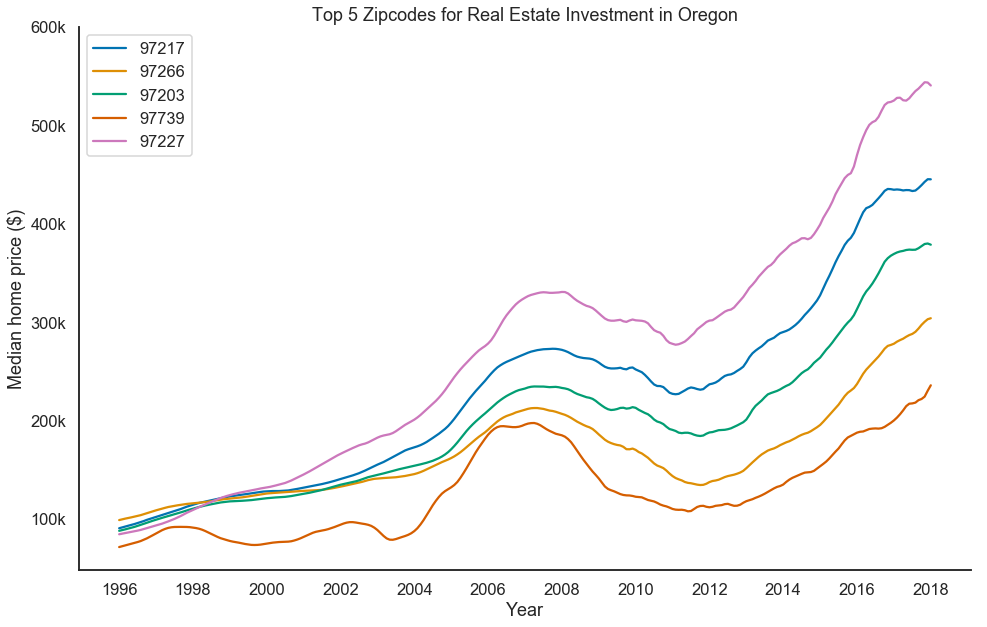

In [19]:
# Plot the top 5 zipcodes
xticks = ['1996-04', '1998-04', '2000-04', '2002-04', '2004-04', '2006-04', 
          '2008-04', '2010-04', '2012-04', '2014-04', '2016-04', '2018-04']
xlabels = ['1996', '1998', '2000', '2002', '2004', '2006', '2008', '2010',
           '2012', '2014', '2016', '2018']
yticks = [100000, 200000, 300000, 400000, 500000, 600000]
ylabels = ['100k', '200k', '300k', '400k', '500k', '600k']

plt.figure(figsize=(16,10))
for index in top_data.index:
    sample = top_data.loc[index,'1996-04':'2018-04']
    zipcode = top_data.loc[index]['RegionName']
    plt.plot(sample, label=top_data.loc[index]['RegionName'])
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.legend()
plt.title('Top 5 Zipcodes for Real Estate Investment in Oregon')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
sns.despine()
plt.show();

I like the fact that, in addition to offering good ROI, these five zipcodes also represent a range of price points at present. For the cost of one median-priced home in Portland 97227, one could buy two in La Pine 97739!

## Least loss during recession (Jan. 2007 v. Jun. 2011)

Although the top 5 zipcodes showed strong ROI over various time intervals, it's important to consider how much value they lost during the recession. This may be an indicator of how they would fare in a future downturn of the housing market.

To calculate loss due to the recession, I will compare median home prices in January 2007, before the recession began, to prices in June 2011, which is at or near the recession low-point for each of these zipcodes. I will use the difference in these values (expressed as a percent of the pre-crash value) as a rough proxy for the risk of investing in each zipcode. To put each zipcode in a statewide perspective, I also assign a rank based on how much median home price changed. The zipcode whose median home price declined the least (or even grew) during the recession would rank at number 1, while the zipcode hit hardest by the recession would rank 224th.

In [20]:
# Calculate loss in median home value during recession period
# Rank zipcodes by amount lost (rank 1 = least loss)
oregon_copy = oregon.copy()
oregon_copy['rec_loss'] = np.abs(oregon_copy['2011-06'] - oregon_copy['2007-01'])
oregon_copy['rec_loss_pct'] = oregon_copy['rec_loss']/oregon_copy['2007-01']
least_rec_loss = oregon_copy.sort_values('rec_loss_pct', ascending=False)
least_rec_loss['rank'] = least_rec_loss['rec_loss_pct'].rank()
least_rec_loss.tail(10)

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,rec_loss,rec_loss_pct,rank
10317,97352,Jefferson,OR,Salem,Marion,84300.0,84600.0,84900.0,85300.0,85800.0,...,213300,215800,218300,221000,223500,226500,228600,15200.0,0.097561,10.0
4423,97333,Corvallis,OR,Corvallis,Benton,67300.0,67500.0,67600.0,67600.0,67600.0,...,326400,329400,332300,334400,333200,329600,326700,22600.0,0.090509,9.0
5779,97850,La Grande,OR,La Grande,Union,89800.0,90400.0,91000.0,91600.0,92200.0,...,169800,170800,171900,172600,173100,173700,174400,9200.0,0.067251,8.0
4270,97838,Hermiston,OR,Hermiston-Pendleton,Umatilla,97700.0,97600.0,97600.0,97700.0,98000.0,...,179900,179600,179800,180900,182200,184200,185800,6100.0,0.045085,7.0
12987,97883,Union,OR,La Grande,Union,78400.0,78900.0,79400.0,79800.0,80200.0,...,145200,147000,148800,149900,150500,151900,153400,3800.0,0.035023,6.0
5082,97801,Pendleton,OR,Hermiston-Pendleton,Umatilla,252000.0,253000.0,254100.0,255200.0,256600.0,...,168700,168700,168900,169900,171100,172900,174400,4300.0,0.032502,5.0
14523,97886,Weston,OR,Hermiston-Pendleton,Umatilla,107000.0,107600.0,108300.0,108900.0,109600.0,...,138700,138700,139600,140500,141200,142700,143800,2400.0,0.021563,4.0
8743,97370,Philomath,OR,Corvallis,Benton,69300.0,69700.0,70000.0,70300.0,70600.0,...,284400,287100,290100,292900,293000,291800,291500,3300.0,0.015981,3.0
13765,97868,Pilot Rock,OR,Hermiston-Pendleton,Umatilla,175300.0,176400.0,177500.0,178500.0,179500.0,...,124400,124900,125500,126300,128000,130800,132600,1200.0,0.011952,2.0
10113,97882,Umatilla,OR,Hermiston-Pendleton,Umatilla,84300.0,84600.0,84900.0,85300.0,85800.0,...,133200,133100,133500,134400,135600,137400,138800,900.0,0.009000,1.0


In [21]:
# View the losses and ranks of the top 5 zipcodes
top_zips_least_loss = least_rec_loss[least_rec_loss.RegionName.isin(top5_zips)]
top_zips_least_loss[['RegionName','rec_loss', 'rank']]

,RegionName,rec_loss,rank
6854,97739,84000.0,216.0
3081,97266,67900.0,190.0
3130,97203,42000.0,48.0
1769,97217,36600.0,22.0
10068,97227,40400.0,17.0


Of the top 5 zipcodes, 97227 suffered the least during the recession, with a drop in median home price of only \$40,400 and an overall rank of 17th in Oregon. 97217 and 97203 also fared relatively well, but 97266 and 97739 were among the hardest hit.

Let's inspect the recession and recovery period for the top 5 zipcodes:

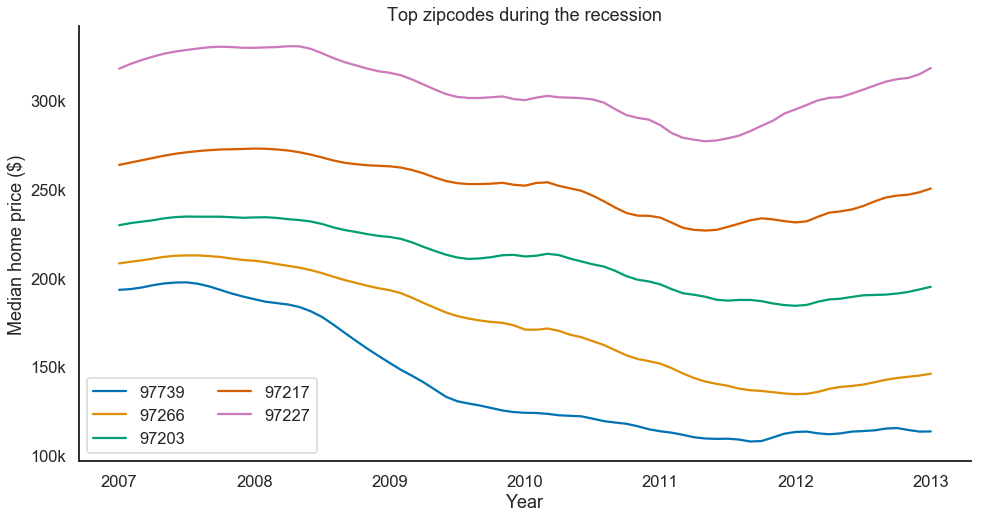

In [22]:
# Plot the top 5 zipcodes over the period Jan. 2007-Jun. 2011
xticks = ['2007-01', '2008-01', '2009-01', '2010-01', '2011-01', '2012-01', '2013-01']
xlabels = ['2007', '2008', '2009', '2010', '2011', '2012', '2013']
yticks = [100000, 150000, 200000, 250000, 300000]
ylabels = ['100k', '150k', '200k', '250k', '300k']

plt.figure(figsize=(16,8))
for n,index in enumerate(top_zips_least_loss.index):
    sample = top_zips_least_loss.loc[index,'2007-01':'2013-01']
    zipcode = top_zips_least_loss.loc[index]['RegionName']
    plt.plot(sample, label=top_zips_least_loss.loc[index]['RegionName'])
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.legend(loc='lower left', ncol=2)
plt.title('Top zipcodes during the recession')
plt.ylabel('Median home price ($)')
plt.xlabel('Year')
sns.despine()
plt.show();

If the decline in median home price during the recession can be used as a proxy for future risk, then 97227 is the least risky of these zipcodes, and 97739 the riskiest. By 2013, when 97227 was making a strong recovery, 97739 was barely turning up again. Keep in mind that 97739 also saw the most growth in median home price over the period 2013-2018, so it eventually made a strong recovery, but 97227 has been a more dependable performer over time.

## Properties currently available

One last feature I want to consider for the top 5 zipcodes is the number of properties currently listed for sale on Zillow. The number of current listings represents how many opportunities there are to invest, and it could give investors an indication of how much choice or competition they might face in that market. 

Zillow collects data on numbers of listings monthly for some zipcodes, but not all. I found monthly listing counts for just 97210 and 97034, which I plotted below. I collected current listing counts for the other zipcodes manually by searching Zillow for current listings. 

In [23]:
# Load listings data
listings = pd.read_csv('zillow_listings_counts.csv')
listings.head()

,SizeRank,RegionID,RegionName,RegionType,StateName,2013-01,2013-02,2013-03,2013-04,2013-05,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,61639,10025,Zip,NY,338.0,332.0,325.0,316.0,308.0,...,259.0,258.0,257.0,269.0,286.0,293.0,286.0,278.0,282.0,287
1,2.0,84654,60657,Zip,IL,510.0,503.0,484.0,483.0,483.0,...,491.0,510.0,504.0,495.0,518.0,545.0,564.0,580.0,579.0,574
2,3.0,61637,10023,Zip,NY,449.0,435.0,436.0,436.0,437.0,...,523.0,508.0,489.0,483.0,492.0,511.0,521.0,520.0,525.0,537
3,4.0,91982,77494,Zip,TX,948.0,932.0,889.0,860.0,835.0,...,941.0,962.0,947.0,934.0,958.0,972.0,962.0,948.0,908.0,875
4,5.0,84616,60614,Zip,IL,584.0,566.0,525.0,500.0,499.0,...,629.0,644.0,665.0,699.0,739.0,743.0,724.0,714.0,698.0,690


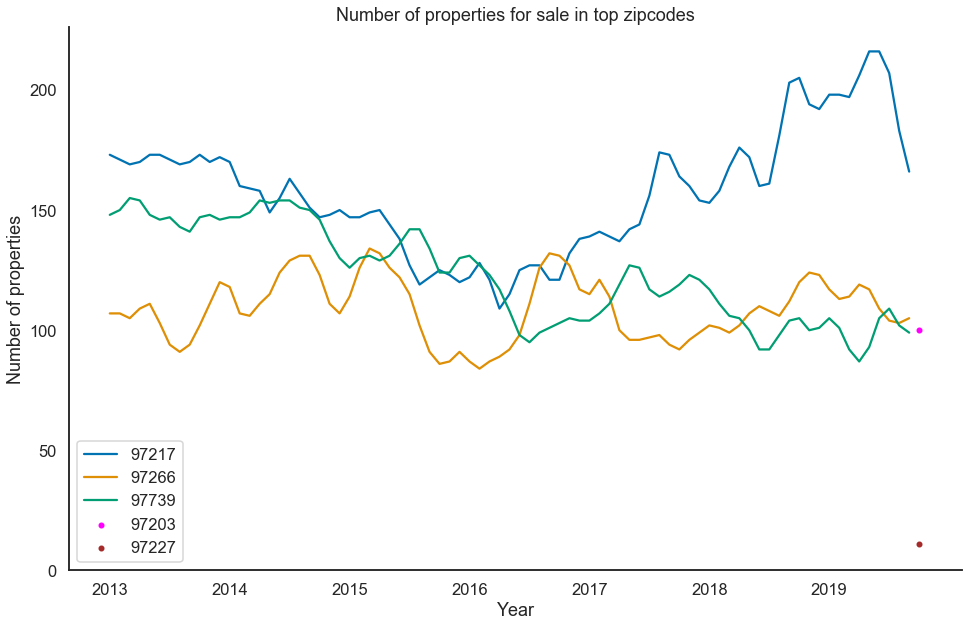

In [24]:
# Plot listings history for 97210 and 97034, current listings for other zips
top_listings = listings[listings.RegionName.isin(top5_zips)]
xticks = ['2013-01', '2014-01', '2015-01', '2016-01', '2017-01', '2018-01', '2019-01']
xlabels = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']


plt.figure(figsize=(16,10))
for n,index in enumerate(top_listings.index):
    sample = top_listings.loc[index,'2013-01':'2019-09']
    zipcode = top_listings.loc[index]['RegionName']
    plt.plot(sample, label=zipcode)
plt.scatter('2019-10', 100, marker='.', label='97203', color='fuchsia')
plt.scatter('2019-10', 11, marker='.', label='97227', color='brown')
plt.xticks(xticks, xlabels)
plt.legend(loc='lower left')
plt.title('Number of properties for sale in top zipcodes')
plt.ylabel('Number of properties')
plt.xlabel('Year')
sns.despine()
plt.show();

The plot above illustrates the number of properties available in each zipcode (either over time, if that data was available, or just currently). 

Note that 97217 is a much bigger market, with about 160 properties currently listed for sale, while 97227 has only 11 properties listed this month.

## Summary (non-technical) visualizations

The top five zipcodes for investment in Oregon are 97217, 97266, 97739, 97203, and 97227. The ranking of these five depends on the investor's priorities and risk tolerance. 

Remember that 97266 and 97739 were strong performers for ROI in the short term, 97217 and 97227 in the mid-term, and and 97203 over the whole 22-year dataset.

The charts below summarize the current median home price, current number of properties for sale, and recession-era loss for each of the top 5 zipcodes.

In [25]:
# Collate data for summary barplots
top_5 = ['97266', '97739', '97203', '97217', '97227']
avails = [116, 297, 100, 181, 11]
rec_ranks = [190, 216, 48, 22, 17]
top_5_data = oregon[oregon.RegionName.isin(top_5)]
top_5_data['rec_loss'] = top_5_data['2011-06'] - top_5_data['2007-01']
top_5_data['rec_loss_pct'] = top_5_data['rec_loss']/top_5_data['2007-01']*100
top_5_data['rec_rank'] = [x for x in rec_ranks]
top_5_data['avails'] = [x for x in avails]
top_5_data.sort_values(by='RegionName', axis=0, inplace=True)
top_5_data

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,rec_loss,rec_loss_pct,rec_rank,avails
3130,97203,Portland,OR,Portland,Multnomah,88000.0,88700.0,89500.0,90300.0,91200.0,...,373500,375000,377200,379300,379800,378600,-42000.0,-18.284719,48,100
1769,97217,Portland,OR,Portland,Multnomah,90600.0,91500.0,92300.0,93200.0,94000.0,...,433600,436100,439100,442400,445100,445000,-36600.0,-13.879408,190,116
10068,97227,Portland,OR,Portland,Multnomah,84500.0,85100.0,85800.0,86400.0,87000.0,...,534600,537100,540300,543600,543300,540300,-40400.0,-12.708399,17,11
3081,97266,Portland,OR,Portland,Multnomah,98900.0,99700.0,100400.0,101000.0,101700.0,...,290100,293400,297200,300300,302900,303900,-67900.0,-32.612872,216,297
6854,97739,La Pine,OR,Bend,Deschutes,71500.0,72300.0,73200.0,74100.0,74900.0,...,218200,220700,221900,224300,230300,235800,-84000.0,-43.455768,22,181


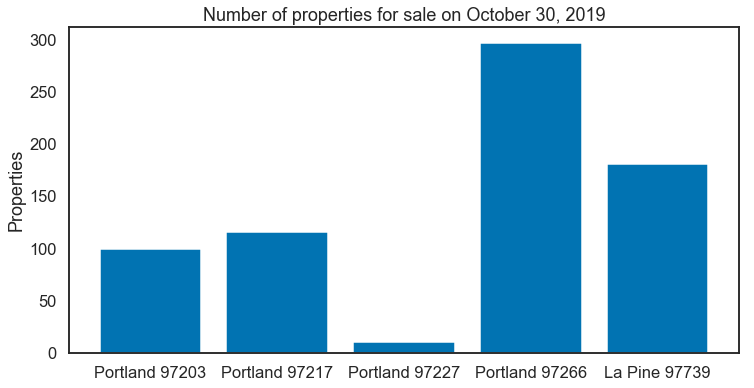

In [26]:
# Plot current number of properties for sale
xticks = ['Portland 97203', 'Portland 97217', 'Portland 97227',
          'Portland 97266', 'La Pine 97739']
plt.figure(figsize=(12,6))
plt.bar(xticks, top_5_data.avails)
plt.xticks(xticks)
plt.ylabel('Properties')
plt.title('Number of properties for sale on October 30, 2019')
plt.show();

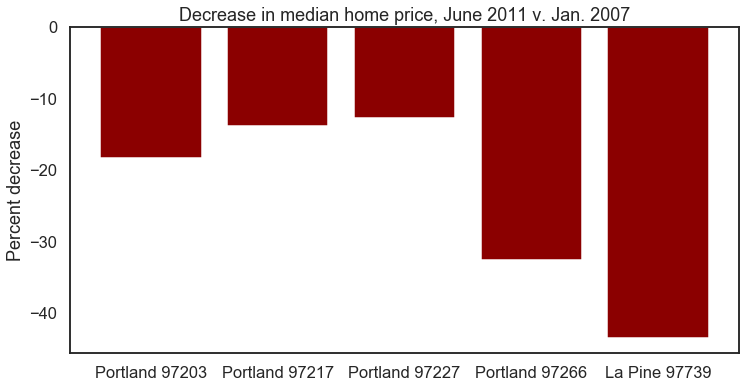

In [27]:
# Plot recession loss percents
plt.figure(figsize=(12,6))
plt.bar(xticks, top_5_data.rec_loss_pct, color='darkred')
plt.xticks(xticks)
plt.ylabel('Percent decrease')
plt.title('Decrease in median home price, June 2011 v. Jan. 2007')
plt.show();

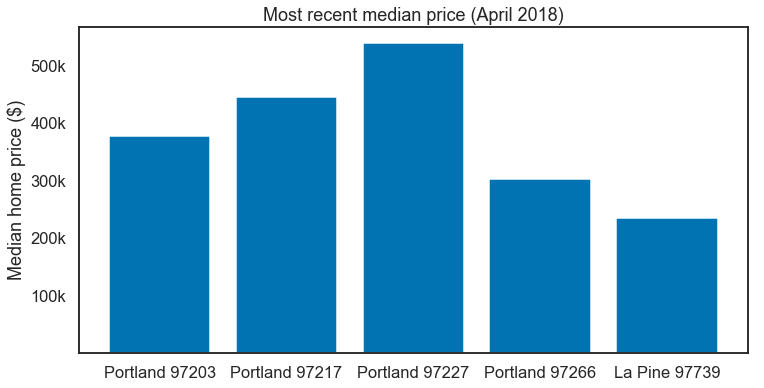

In [28]:
# Plot most recent median home prices
yticks = [100000, 200000, 300000, 400000, 500000]
ylabels = ['100k', '200k', '300k', '400k', '500k']

plt.figure(figsize=(12,6))
plt.bar(xticks, top_5_data['2018-04'])
plt.xticks(xticks)
plt.yticks(yticks, ylabels)
plt.ylabel('Median home price ($)')
plt.title('Most recent median price (April 2018)')
plt.show();

# Extract time series for top 5 zipcodes

Now that I have identified the top 5 zipcodes, I will create a subset of the data for each.

In [29]:
# Drop unwanted columns
or_trimmed = oregon.drop(['City','Metro','State','CountyName'], axis=1)

# Create zipcode subsets
or_97203 = or_trimmed[or_trimmed.RegionName==97203].drop('RegionName', axis=1)
or_97217 = or_trimmed[or_trimmed.RegionName==97217].drop('RegionName', axis=1)
or_97227 = or_trimmed[or_trimmed.RegionName==97227].drop('RegionName', axis=1)
or_97266 = or_trimmed[or_trimmed.RegionName==97266].drop('RegionName', axis=1)
or_97739 = or_trimmed[or_trimmed.RegionName==97739].drop('RegionName', axis=1)

# Preview one zipcode's subset
or_97203.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3130,88000.0,88700.0,89500.0,90300.0,91200.0,92000.0,93000.0,94000.0,95100.0,96200.0,...,372300,373200,373600,373400,373500,375000,377200,379300,379800,378600


Although I now have the data I want, note that it is not in a useful format for modeling. I will reshape and visualize each zipcode's time series below.

# EDA and visualization

In this section I use a custom function (defined above) to transform each time series into an appropriate format for modeling (specifically, the required format for use with Facebook Prophet). My custom function also returns a small plot of the series, just to give us an idea of its shape.

## 97203

,ds,y
0,1996-04-01,88000.0
1,1996-05-01,88700.0
2,1996-06-01,89500.0
3,1996-07-01,90300.0
4,1996-08-01,91200.0


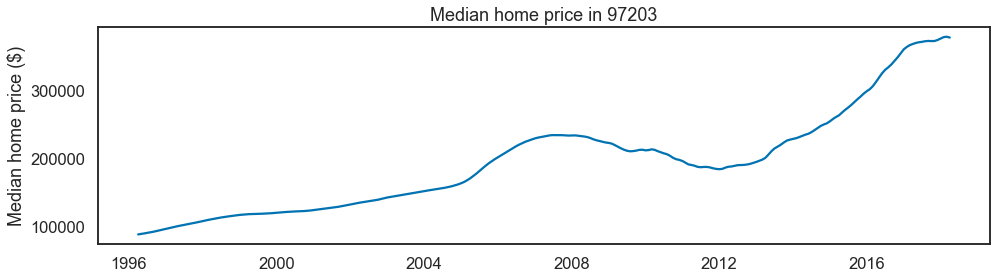

In [30]:
# Transform and plot data from 97203
or_97203, fig = melt_plot(or_97203, '97203')

# Preview the data and view the plot
display(or_97203.head())
fig;

It looks like prices in this zipcode experienced a big growth spurt leading up to the crisis in 2008, followed by a drop that reached its minimum sometime around 2012. It seems to have taken until around 2014 to reach pre-crash levels.

## 97217

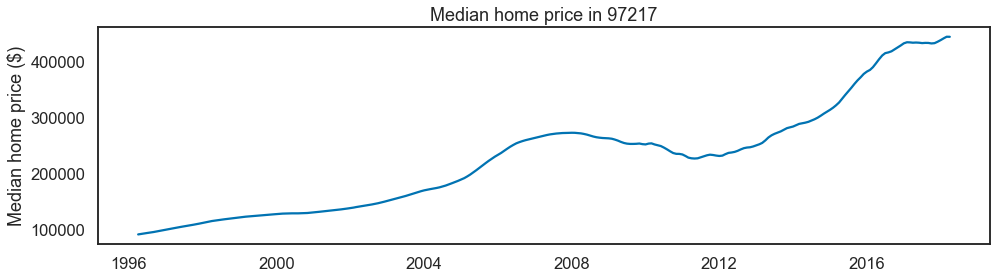

In [31]:
# Transform and plot data from 97217
or_97217, fig = melt_plot(or_97217, '97217')
fig;

In this zipcode, the pre-crash growth spurt was not as dramatic, and the subsequent decline was also not as bad. The median home price seems to have reached its pre-crash level around 2013, a bit quicker than in 97203.

## 97227

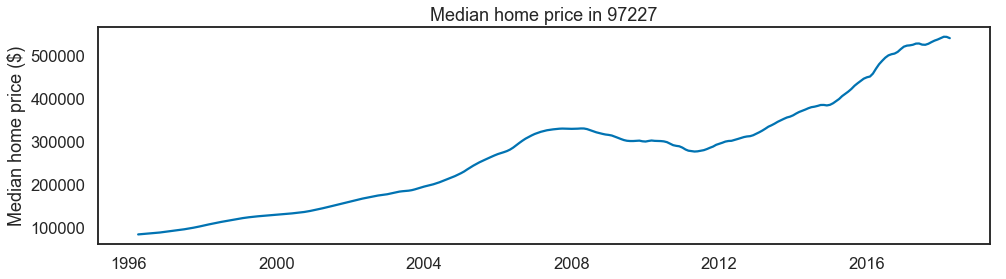

In [32]:
# Transform and plot data from 97227
or_97227, fig = melt_plot(or_97227, '97227')
fig;

Of the 5 zipcodes, this one was the least impacted by the crash. 

## 97266

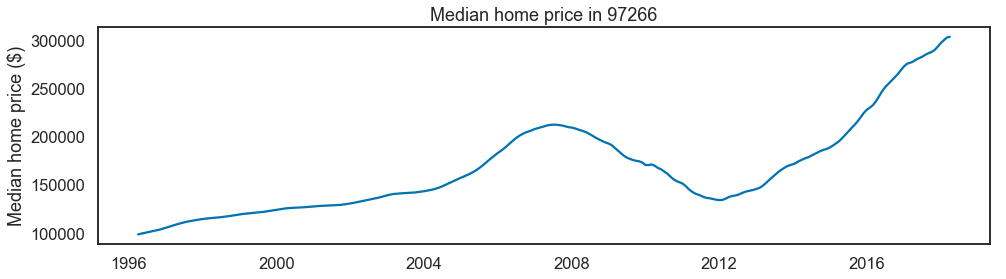

In [33]:
# Transform and plot data from 97266
or_97266, fig = melt_plot(or_97266, '97266')
fig;

Pre-crash growth and post-crash decline both seem pretty dramatic here. Pre-crash level was reached again around 2015.

## 97739

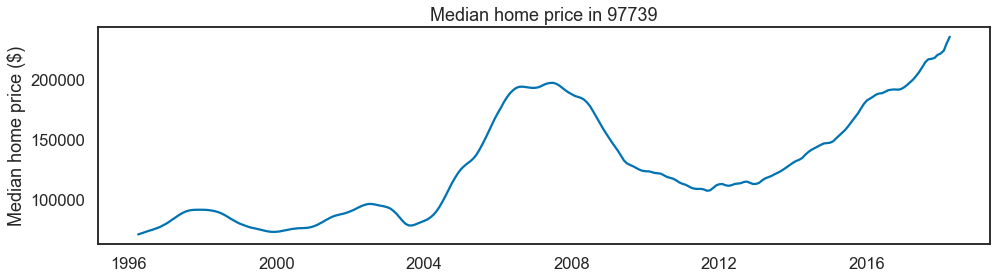

In [34]:
# Transform and plot data from 97739
or_97739, fig = melt_plot(or_97739, '97739')
fig;

La Pine has only been a top performer for ROI in the last 5 years, and it was hit hardest by the recession. It looks like it took until 2016 to reach the pre-crash median price again.

## All together

Finally, let's compare the top 5 zipcodes to the statewide average over time.

In [35]:
# Prep data for OR mean
or_all = or_trimmed.drop('RegionName', axis=1)
or_all_melt = melt_it(or_all)
or_all_melt = or_all_melt.groupby('ds').mean()
or_all_melt.head()

,y
ds,
1996-04-01,124696.428571
1996-05-01,125219.642857
1996-06-01,125730.803571
1996-07-01,126237.946429
1996-08-01,126762.500000


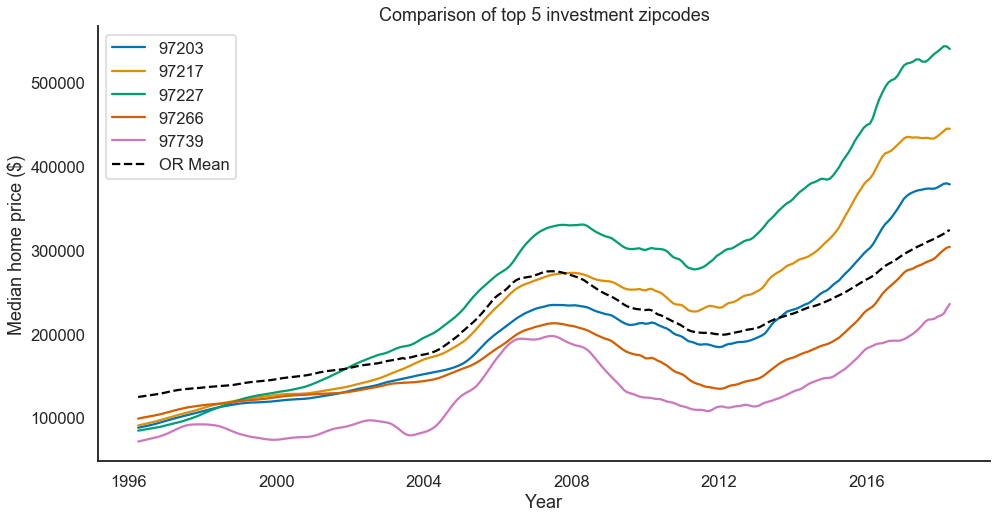

In [36]:
# Plot top 5 zipcodes and OR mean
plt.figure(figsize=(16,8))
plt.plot(or_97203['ds'], or_97203['y'], label='97203')
plt.plot(or_97217['ds'], or_97217['y'], label='97217')
plt.plot(or_97227['ds'], or_97227['y'], label='97227')
plt.plot(or_97266['ds'], or_97266['y'], label='97266')
plt.plot(or_97739['ds'], or_97739['y'], label='97739')
plt.plot(or_all_melt.index, or_all_melt['y'], label='OR Mean',
        linestyle='--', color='k')
plt.legend()
plt.title('Comparison of top 5 investment zipcodes')
plt.xlabel('Year')
plt.ylabel('Median home price ($)')
sns.despine()
plt.show();

I'm glad to see that the five zipcodes represent a range of price points, some above and some below the statewide mean.

# Modeling

Now that I have selected the top 5 zipcodes for investment, I want to build models to predict how they might perform in the future.

I have decided to use [Facebook Prophet](https://facebook.github.io/prophet/) rather than the [Statsmodels SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) package because Prophet handles the selection of ARIMA parameters internally. Selecting ARIMA parameters myself using a grid search could be very time-consuming; I could only consider a small range of possibilities before the operation became very slow and resource-intensive. Prophet has the advantages of being easy to use, concise, and fast, and it produces attractive plots of the model and predictions. Prophet can also output separate plots of the trend and seasonality in the data on multiple scales (daily, weekly, monthly). I appreciate being able to access a convenient DataFrame of the predictions with the upper and lower bounds of their confidence intervals.

My method is as follows:
1. Split each zipcode's data into "training" and "validation" sets, reserving the last 10% of each time series for validation.
2. View a quick plot of the data to confirm that the split worked and to get a sense of whether the validation series differs dramatically from the training series.
3. Fit a model to the training series.
4. Predict values for the period covered by the validation series.
5. Compare the predictions to the actual values of the validation series. 
6. Fit a new model to the entire series (training and validation combined).
7. Using the second model, forecast median home prices over the next 60 months.

Steps 1 and 2 are wrapped in a custom function that returns the training and validation series and prints the plot. Steps 3 through 7 use Prophet and are wrapped in a custom function that prints plots of the various models and returns two DataFrames: one containing the predicted values to be compared to the validation series, and the other containing the 60-month forecast values.

In [37]:
# Reset context to 'paper' since the following plots are for analysis only
sns.set_context('paper')

## 97203

### Train-test split

Because all the zipcodes took a hard dip during the recession, I want to make sure that my training set incorporates some of the upswing as the housing market exited the recession. For this reason, I will reserve the last 10% (2 years and 4 months) of the data for testing.

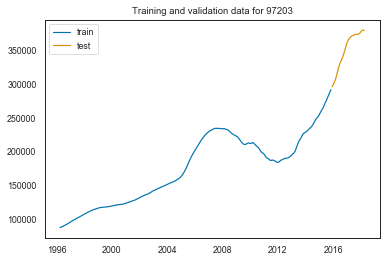

In [38]:
# Split and plot data for 97203
or_97203_train, or_97203_test = prep_and_plot(or_97203, '97203')

### Modeling and forecasting

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


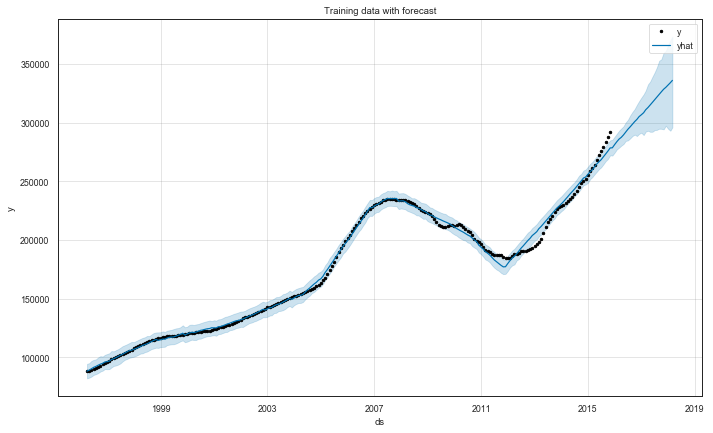

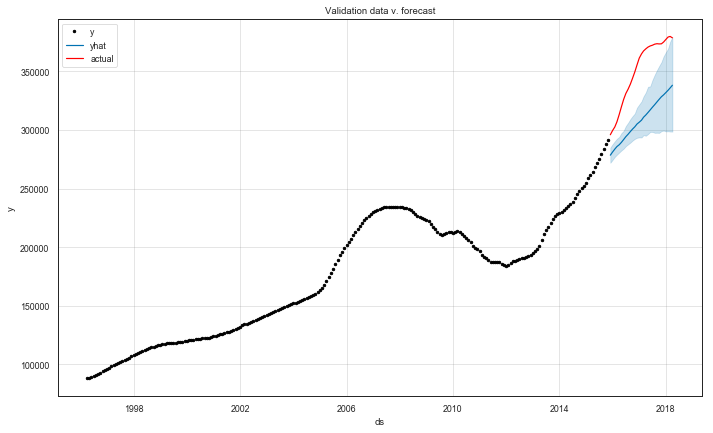

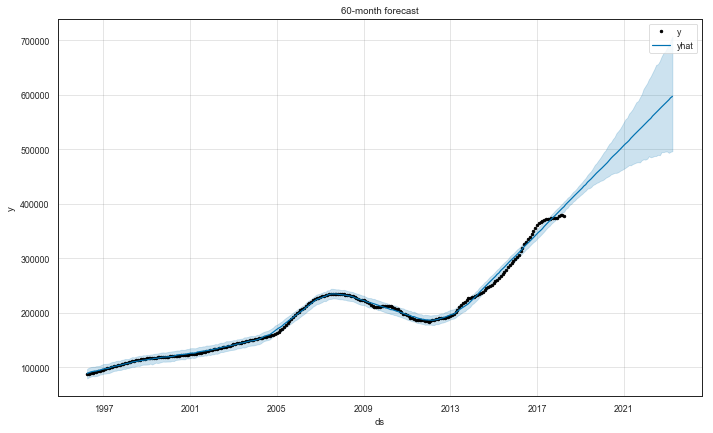

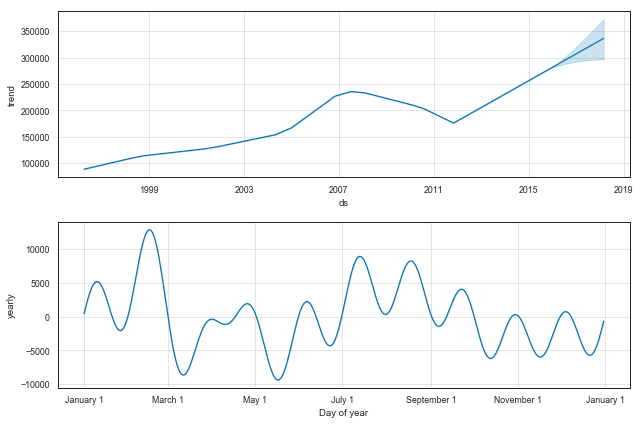

In [39]:
# Get predictions and plot models
ypred_97203, forecast_97203 = proph_it(or_97203_train, or_97203_test, or_97203)

To get a sense for how the model performed, we can compare the predicted value to the actual value at the latest date involved in the prediction (April 2018).

In [40]:
# Compare predicted v. actual values for 2018-04
pred_diff_97203 = round((ypred_97203.loc[28,'yhat'] - or_97203_test.loc[28,'y'])/or_97203_test.loc[28,'y']*100, 2)
pred_diff_97203

-10.68

This calculation tells us that the predicted value was 10% lower than the actual value by the end of the prediction period.

What median home price can we expect for this zipcode five years in the future?

In [41]:
# Print last predicted value and confidence interval
last_pred_97203, ci_97203 = last_forecast(forecast_97203)

Prediction for last date of period:
Median home price: $597322.65
95% CI: (707300.6, 496684.09)


## 97217

### Train-test split

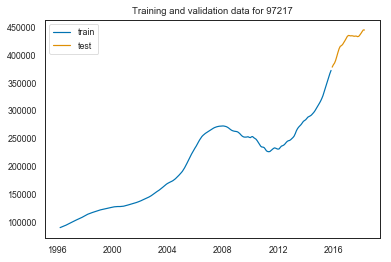

In [42]:
# Split and plot data for 97217
or_97217_train, or_97217_test = prep_and_plot(or_97217, '97217')

### Modeling and forecasting

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


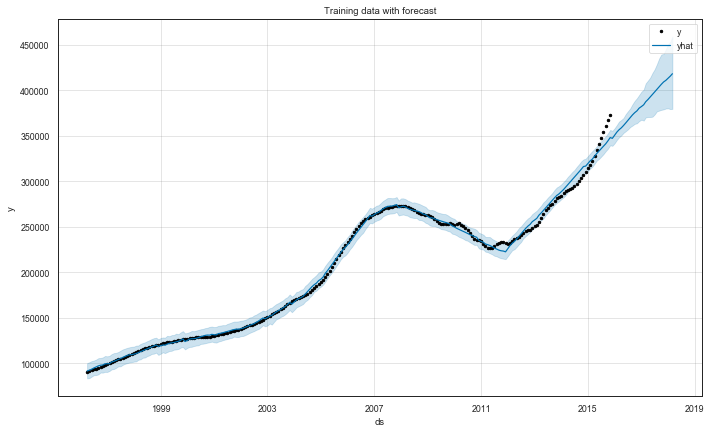

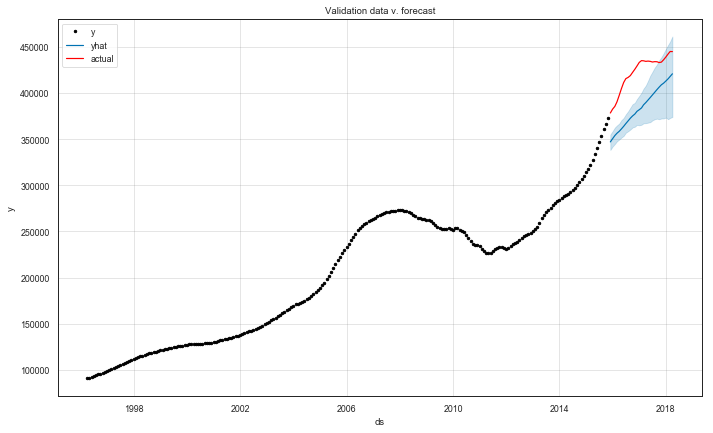

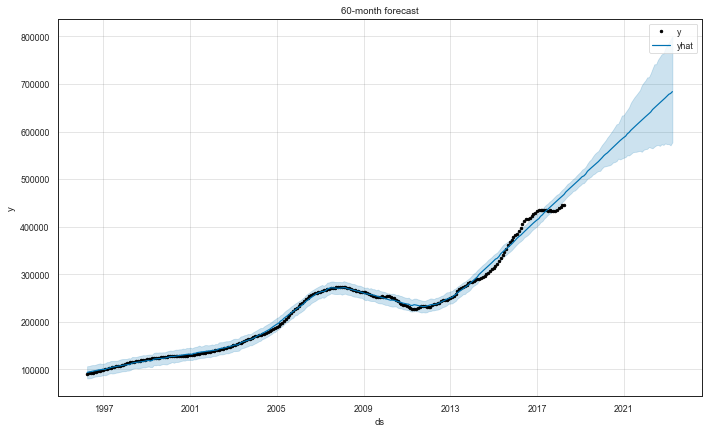

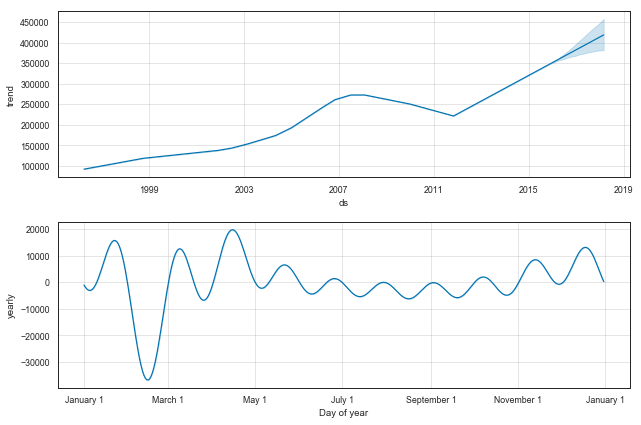

In [43]:
# Get predictions and plot models
ypred_97217, forecast_97217 = proph_it(or_97217_train, or_97217_test, or_97217)

In [44]:
# Compare predicted v. actual values for 2018-04
pred_diff_97217 = round((ypred_97217.loc[28,'yhat'] - or_97217_test.loc[28,'y'])/or_97217_test.loc[28,'y']*100, 2)
pred_diff_97217

-5.41

For zipcode 97217, the model was off by only 5\% by April 2018.

What median home price does the model predict for April 2023?

In [45]:
# Print last predicted value and confidence interval
last_pred_97217, ci_97217 = last_forecast(forecast_97217)

Prediction for last date of period:
Median home price: $684008.46
95% CI: (800031.04, 577596.17)


## 97227

### Train-test split

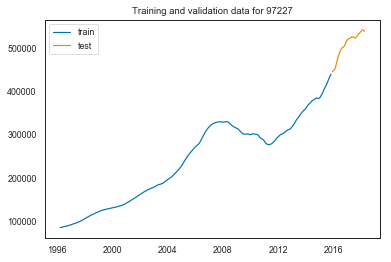

In [46]:
# Split and plot data for 97227
or_97227_train, or_97227_test = prep_and_plot(or_97227, '97227')

### Modeling and forecasting

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


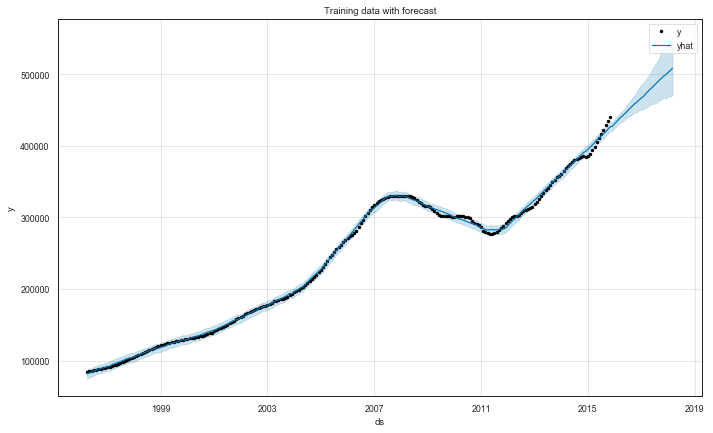

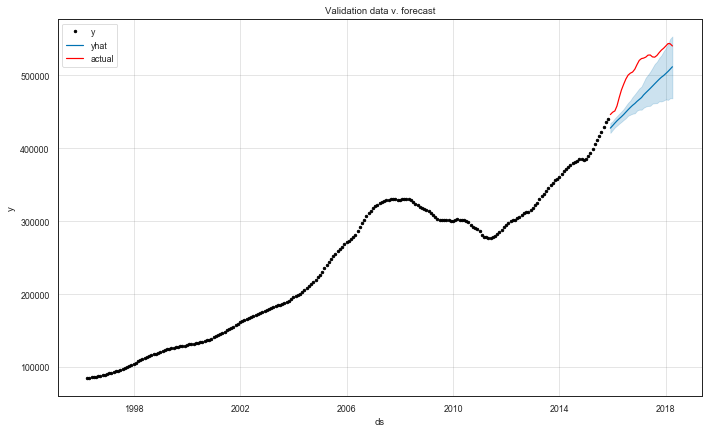

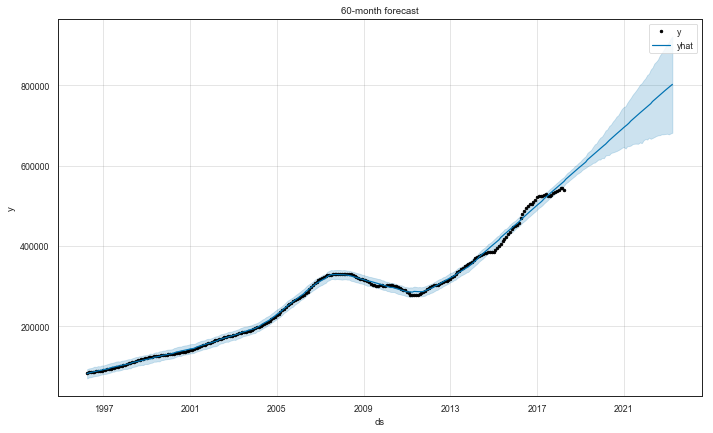

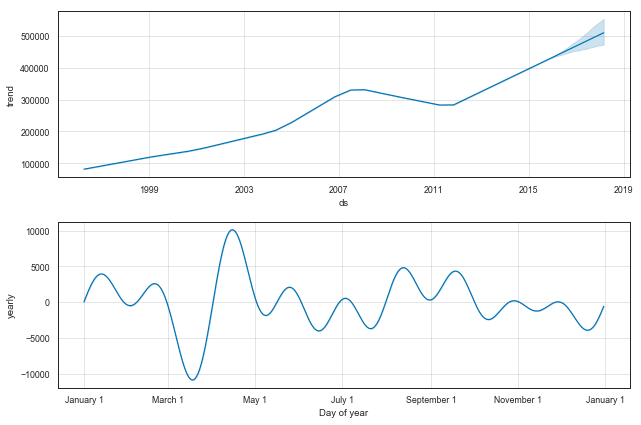

In [47]:
# Get predictions and plot models
ypred_97227, forecast_97227 = proph_it(or_97227_train, or_97227_test, or_97227)

In [48]:
# Compare predicted v. actual values for 2018-04
pred_diff_97227 = round((ypred_97227.loc[28,'yhat'] - or_97227_test.loc[28,'y'])/or_97227_test.loc[28,'y']*100, 2)
pred_diff_97227

-5.28

Here again the model was off by only 5%.

What's the prediction for April 2023?

In [49]:
# Print last predicted value and confidence interval
last_pred_97227, ci_97227 = last_forecast(forecast_97227)

Prediction for last date of period:
Median home price: $801983.84
95% CI: (921236.55, 681665.21)


## 97266

### Train-test split

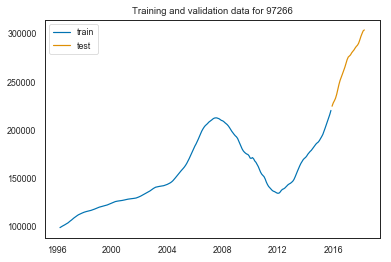

In [50]:
# Split and plot data for 97266
or_97266_train, or_97266_test = prep_and_plot(or_97266, '97266')

### Modeling and forecasting

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


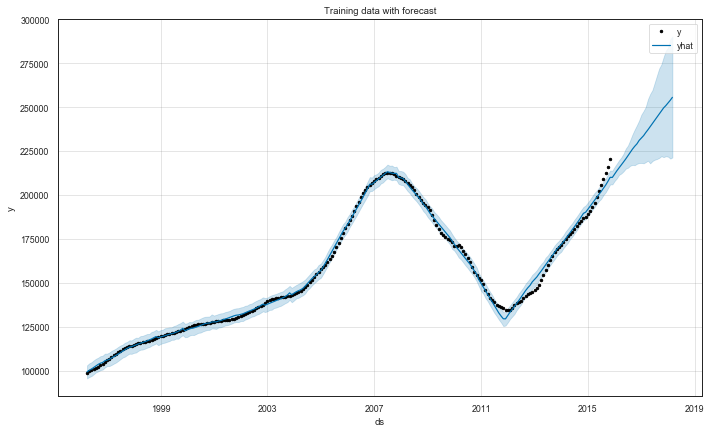

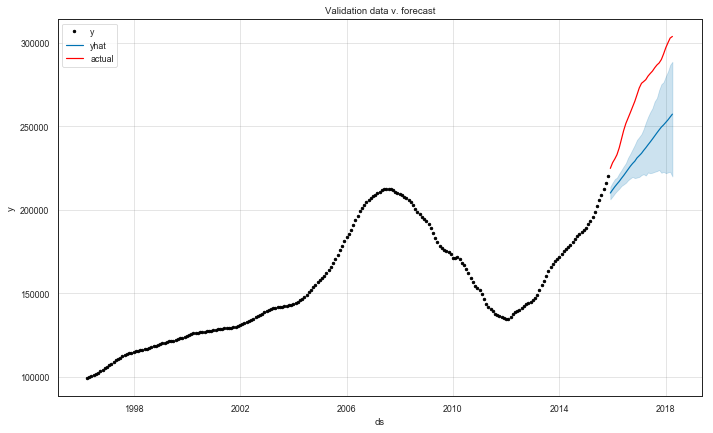

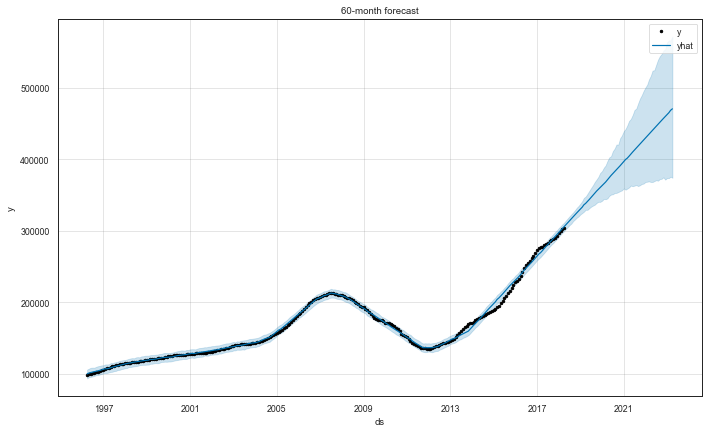

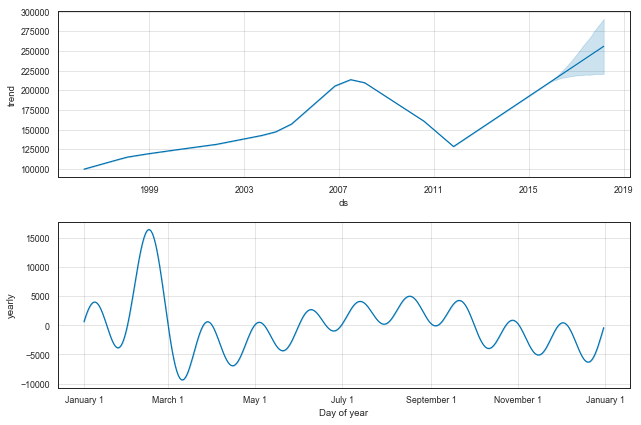

In [51]:
# Get predictions and plot models
ypred_97266, forecast_97266 = proph_it(or_97266_train, or_97266_test, or_97266)

In [52]:
# Compare predicted v. actual values for 2018-04
pred_diff_97266 = round((ypred_97266.loc[28,'yhat'] - or_97266_test.loc[28,'y'])/or_97266_test.loc[28,'y']*100, 2)
pred_diff_97266

-15.33

For zipcode 97266, the model did not perform as well; it was off by 15% by April 2018.

What might the median home price be in 2023, assuming the model performs well?

In [53]:
# Print last predicted value and confidence interval
last_pred_97266, ci_97266 = last_forecast(forecast_97266)

Prediction for last date of period:
Median home price: $470504.66
95% CI: (571653.69, 374120.19)


## 97739

### Train-test split

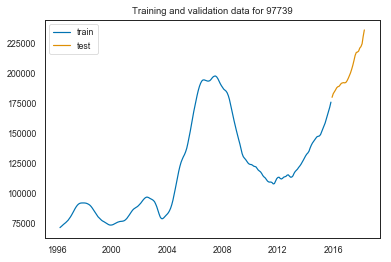

In [54]:
# Split and plot data for 97739
or_97739_train, or_97739_test = prep_and_plot(or_97739, '97739')

### Modeling and forecasting

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


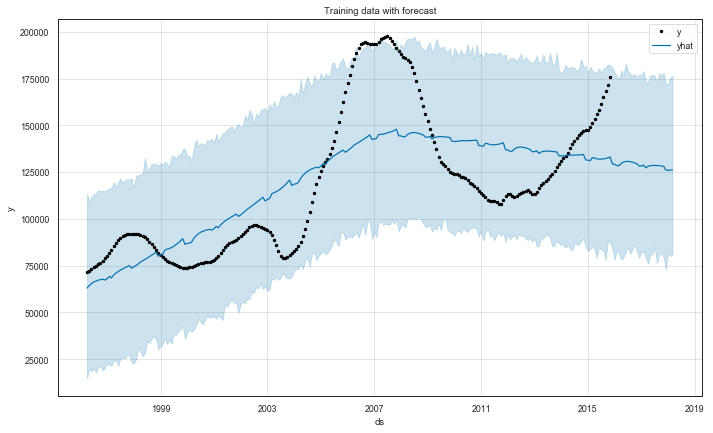

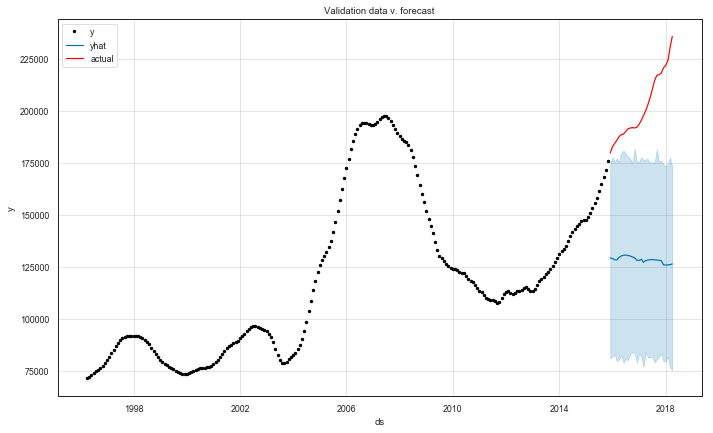

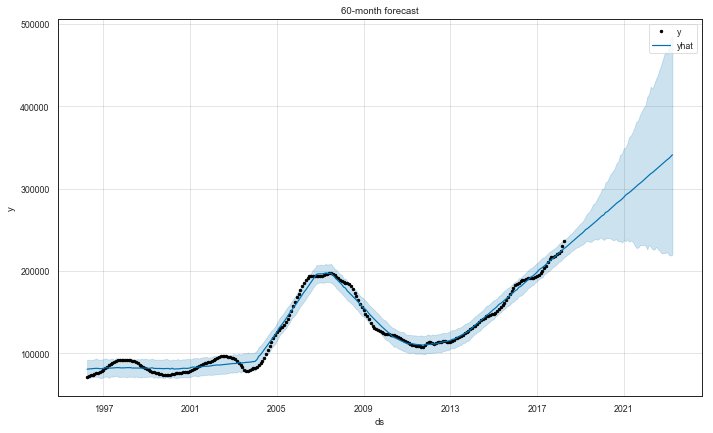

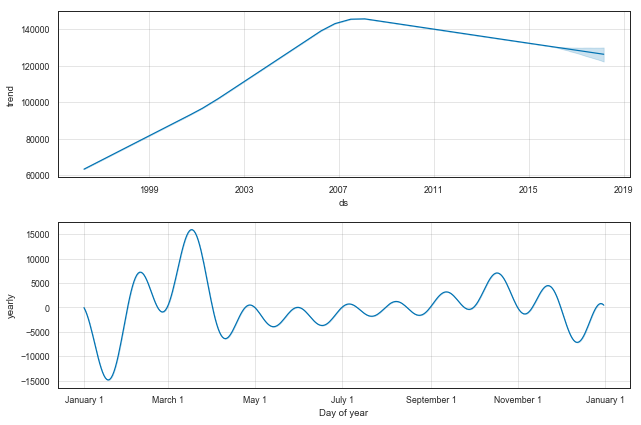

In [55]:
# Get predictions and plot models
ypred_97739, forecast_97739 = proph_it(or_97739_train, or_97739_test, or_97739)

In [56]:
# Compare predicted v. actual values for 2018-04
pred_diff_97739 = round((ypred_97739.loc[28,'yhat'] - or_97739_test.loc[28,'y'])/or_97739_test.loc[28,'y']*100, 2)
pred_diff_97739

-46.36

I'm not at all surprised to see that the model has a hard time predicting values for 97739. This zipcode experienced a boom just before the recession, a big drop during the recession, and then a dramatic recovery in the last five years. This combination of events makes it hard for the model to find a consistent pattern over the last 22 years on which to base its predictions.

Let's take a look at the prediction for April 2023 anyway:

In [57]:
# Print last predicted value and confidence interval
last_pred_97739, ci_97739 = last_forecast(forecast_97739)

Prediction for last date of period:
Median home price: $341169.86
95% CI: (484852.13, 219799.41)


#### Sidetrack: modeling and predicting for 97739 using only the last 5 years' data

The model for 97739 is performing poorly, and it's no wonder: the zipcode has seen some wild fluctuation in median home price in the last 22 years. I'm going to try the model again, this time using only the last 5 years' worth of data, to see how that changes things. 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


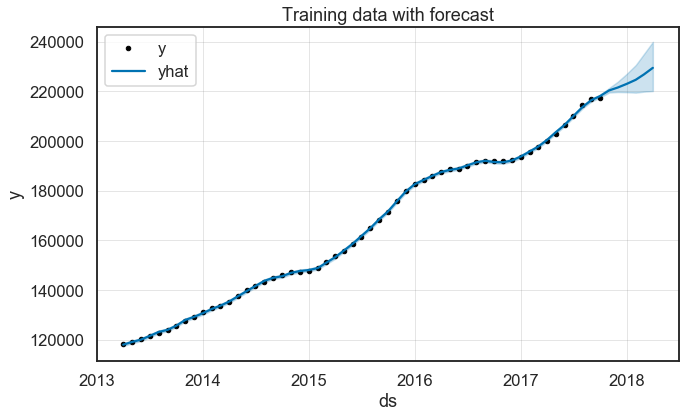

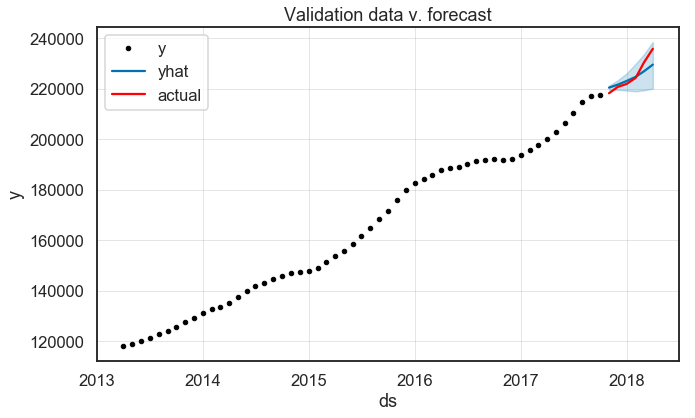

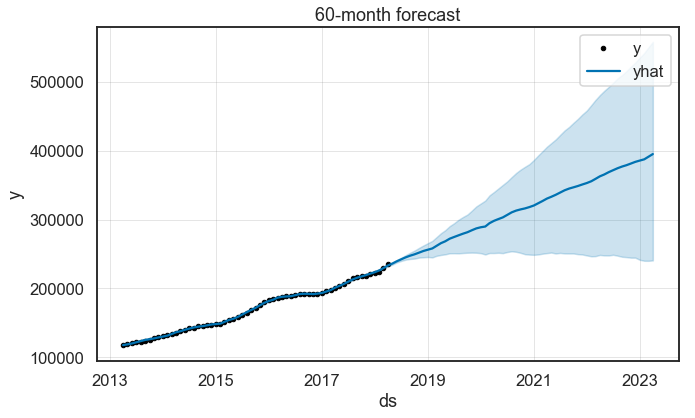

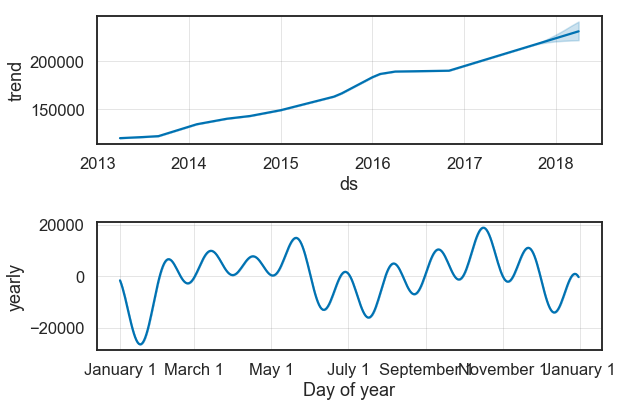

In [111]:
# Slice the 97739 data from index 204 onward to get last 5 years' data
or_97739_5 = or_97739[204:]
or_97739_5_train = or_97739[204:259]
or_97739_5_test = or_97739[259:]

or_97739_5_test.reset_index(inplace=True)

# Get predictions and plot models
ypred_97739_5, forecast_97739_5 = proph_it(or_97739_5_train, or_97739_5_test, 
                                            or_97739_5,
                                            forecast_periods1=6, 
                                            forecast_periods2=60)

In [112]:
# Compare predicted v. actual values for 2018-04
pred_diff_97739_5 = round((y_pred_97739_5.loc[44,'yhat'] - or_97739_5_test.loc[5,'y'])/or_97739_5_test.loc[5,'y']*100, 2)
pred_diff_97739_5

0.8

That's the smallest percent difference between predicted and actual values I've seen so far&mdash;less than 1%!&mdash;and the only positive value. This model, however, only had to predict over the last 10% (6 months) of a much smaller series; there was less opportunity for it to stray.

Although this 5-year model _seemed_ to perform much better than the 22-year one, keep in mind that it is only looking at part of the history of 97739. If the model fits just this little part of the data very well (i.e., if it is overfitting in the grand scheme of things), then its predictions will probably only continue to be this good for a short time into the future.

Let's examine its prediction for April 2023:

In [72]:
# Print last predicted value and confidence interval
last_pred_97739_5, ci_97739_5 = last_forecast(forecast_97739_5)

Prediction for last date of period:
Median home price: $395151.2
95% CI: (565259.65, 220174.0)


The values predicted by the two models only differ by about \$54k, and note that the 95\% confidence interval of the 5-year model contains that of the 22-year model. 

Let's visualize this:

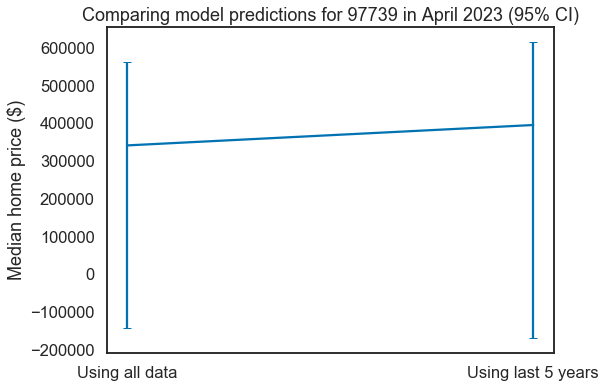

In [114]:
# Compare forecasts and CIs for two models
ci_vals = np.array([[ci_97739[0], ci_97739_5[0]], [ci_97739[1], ci_97739_5[1]]])
y_vals = [last_pred_97739, last_pred_97739_5]
x_vals = ['Using all data', 'Using last 5 years']

sns.set_context('talk')
plt.figure(figsize=(8,6))
plt.errorbar(x_vals, y_vals, yerr=ci_vals, capsize=4)
plt.title('Comparing model predictions for 97739 in April 2023 (95% CI)')
plt.ylabel('Median home price ($)')
plt.show();


These confidence intervals are so wide&mdash;they're predicting that median home price could shoot up over \$550k or drop below 0! Ultimately, I wouldn't trust either of these models to predict what might happen in 2023, but I would feel fairly confident in either of them up to 2019 or maybe 2020. Since it's currently October 2019, this doesn't do anybody much good. If I had data up to the present, I would feel confident in predicting prices a year or so into the future, which would be useful for flippers, but not so much for long-term investors.

# Interpretations and recommendations

Now that the modeling is complete, I can offer some interpretations of the results and model-based recommendations for investors.

## Comparing model performance

Recall that I decided to validate each model by using it to predict values for the period from 2015-2018, a period for which I actually had data set aside. To assess how each model performed, I compare the model's prediction for the last date of the validation period&mdash;April 2018&mdash; with the actual value recorded for that date. I then express the difference between the predicted and actual values as a percentage of the actual value. 

If that percentage is small, it means that the model was not very far off from the actual values by the end of the validation period, and I can feel more confident in the model's ability to predict with reasonable accuracy (although with decreasing precision) into the future.

If the percentage is large, it means that the model was not as close to the actual values by the end of the validation period, and presumably it would continue to stray farther as it forecasts into the future. I would have less confidence in a model like this.

Let's take a look:

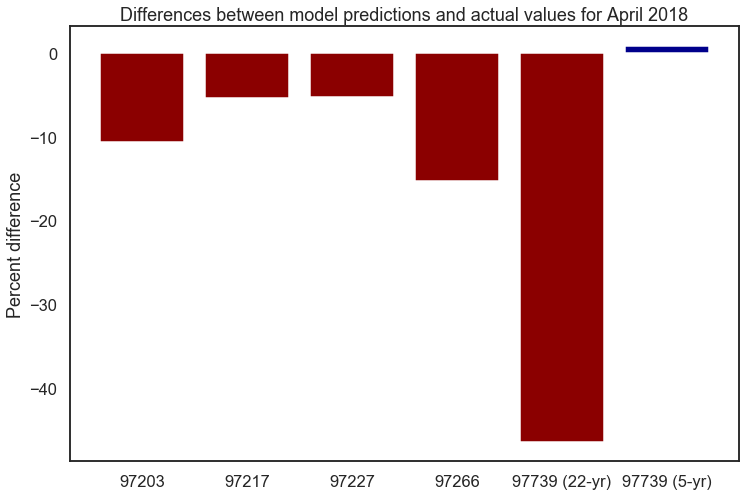

In [115]:
# Plot percent differences of last predictions and actual values
labels = ['97203', '97217', '97227', '97266', '97739 (22-yr)', '97739 (5-yr)']
values = [pred_diff_97203, pred_diff_97217, pred_diff_97227, pred_diff_97266, 
          pred_diff_97739, pred_diff_97739_5]

plt.figure(figsize=(12,8))
plt.bar(labels, values, color='darkred')
plt.bar('97739 (5-yr)', pred_diff_97739_5, color='darkblue')
plt.title('Differences between model predictions and actual values for April 2018')
plt.ylabel('Percent difference')
plt.show();

To recap: for each zipcode, I trained a model on the first 90% of the time series and then asked the model to predict how median home price would rise in the last 10% (from 2015 to April 2018).

For each of these zipcodes, the models underestimated the actual median home price in April 2018. For 97217 and 97227, the models were only off by about 5%, while for 97739 the model underestimated the price by over 40%. I made a new model for 97739 using just the last 5 years' worth of data, and this model overestimated the price by 0.8%.

Over the five year period after April 2018, I would place more confidence in the models for 97217 and 97227 than for the others. Neither of the models for 97739 is very reliable, but the 5-year model may be good at predicting home price for the first year or so.

Here is a summary of where the various models predict that median home prices will end up by April 2023:

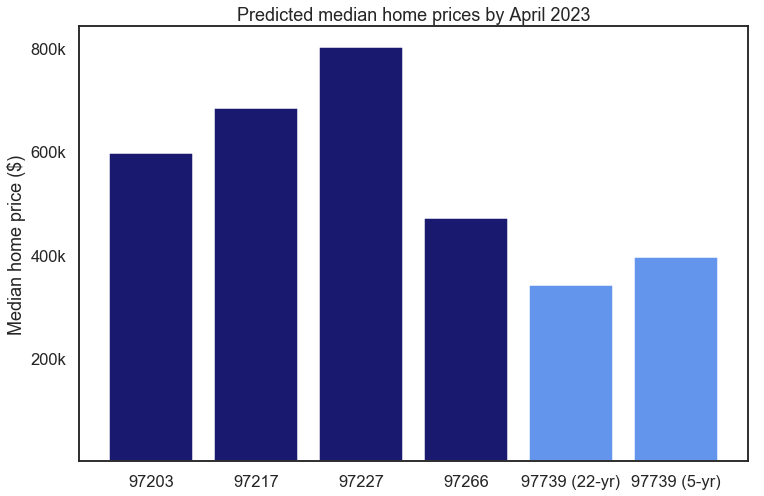

In [116]:
# Plot predicted median home prices in 2023
labels = ['97203', '97217', '97227', '97266', '97739 (22-yr)', '97739 (5-yr)']
preds = [last_pred_97203, last_pred_97217, last_pred_97227, last_pred_97266, 
         last_pred_97739, last_pred_97739_5]
yticks = [200000, 400000, 600000, 800000]
ylabels = ['200k', '400k', '600k', '800k']

plt.figure(figsize=(12,8))
plt.bar(labels, preds, color='midnightblue')
plt.bar(['97739 (22-yr)', '97739 (5-yr)'], [last_pred_97739, last_pred_97739_5], 
        color='cornflowerblue')
plt.yticks(yticks,ylabels)
plt.title('Predicted median home prices by April 2023')
plt.ylabel('Median home price ($)')
plt.show();

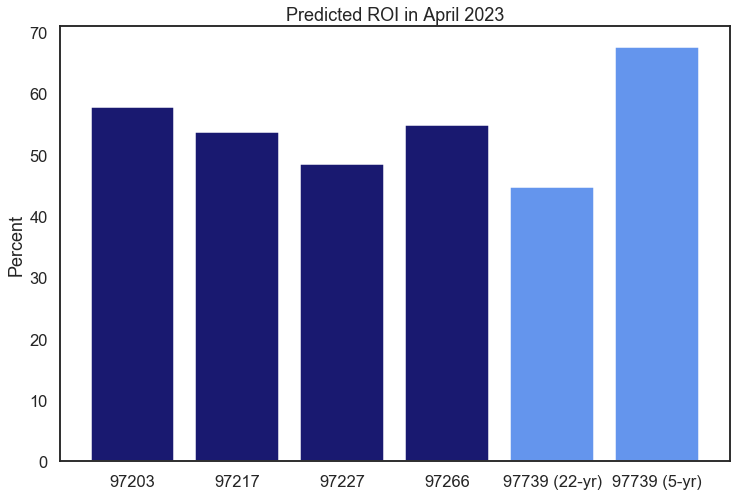

In [103]:
# Calculate ROI over period April 2018-April 2023
pred_roi_97203 = round((last_pred_97203 - or_97203_test.loc[28,'y'])/or_97203_test.loc[28,'y']*100,2)
pred_roi_97217 = round((last_pred_97217 - or_97217_test.loc[28,'y'])/or_97217_test.loc[28,'y']*100,2)
pred_roi_97227 = round((last_pred_97227 - or_97227_test.loc[28,'y'])/or_97227_test.loc[28,'y']*100,2)
pred_roi_97266 = round((last_pred_97266 - or_97266_test.loc[28,'y'])/or_97266_test.loc[28,'y']*100,2)
pred_roi_97739a = round((last_pred_97739 - or_97739_test.loc[28,'y'])/or_97739_test.loc[28,'y']*100,2)
pred_roi_97739b = round((last_pred_97739_5 - or_97739_5_test.loc[5,'y'])/or_97739_5_test.loc[5,'y']*100,2)

preds = [pred_roi_97203, pred_roi_97217, pred_roi_97227, pred_roi_97266, 
         pred_roi_97739a, pred_roi_97739b]

# Plot predicted ROI
plt.figure(figsize=(12,8))
plt.bar(labels, preds, color='midnightblue')
plt.bar(['97739 (22-yr)', '97739 (5-yr)'], [pred_roi_97739a, pred_roi_97739b], 
        color='cornflowerblue')
plt.title('Predicted ROI in April 2023')
plt.ylabel('Percent')
plt.show();

## Recommendations

The five zipcodes I selected offer a range of choices and opportunities for investors, depending on their particular priorities and tolerance for risk. 

In Portland, 97227 and 97217 are safe bets, although they can be competitive markets for investors. Both models performed fairly well, and they predict ROIs of 48% and 53%, respectively, in 2023. These are also the most expensive zipcodes, and they have the least number of properties currently listed, so the opportunity to invest in them is limited. During the recession, however, these two zipcodes fared the best, and this suggests that they may be able to weather future market downturns just as well.

For a riskier undertaking, 97739 in La Pine (Bend) offers a moderate number of low-priced properties with the potential for 45% ROI (using the 22-year model) or 68% ROI (using the 5-year model). This particular market has seen some volatility over the last two decades, and of the five considered here, this zipcode suffered the worst during the recession. If the risk is tolerable, an investor could buy two homes in 97739 for the price of one in 97727, and at the moment, there are plenty of properties in 97739 to choose from.

For those who want to invest in Portland but can't handle the competition (and sticker prices) in 97227 or 97217, 97266 is a good alternative. Prices are lower, and there are plenty of properties currently listed for sale. Although I have less confidence in this model than in those for 97227 and 97217, I think a 55% ROI by 2023 is not a bad estimate. Keep in mind that this zipcode took a big hit during the recession, but it has more than recovered since then.

## Future work

Since the dataset only goes up to April 2018, it would be great to check the model predictions against actual values up to the present. Ideally, one would build the models into a pipeline so that they could be continuously updated as new data comes in. 

I would also like to incorporate additional data about these zipcodes to better understand whether median home price can really keep growing as predicted. For instance, I could use information about wage growth in Portland to determine whether prices in the Portland zipcodes are already close to the maximum the market will allow. 

It would also be helpful to do more research on the history of La Pine over the last 22 years. What happened there to prompt the rapid growth in home prices in the mid-2000s, and is the current rapid growth sustainable?